## Assignment 3

In [3]:
%pip install pymc pytensor

In [4]:
import pymc as pm

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression #for standard linear regression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler



### California Housing Dataset

In [5]:
# Load California housing data
housing = fetch_california_housing()
X, y = housing.data, housing.target

In [6]:
housing

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n

In [7]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#X_train_scaled = X_train
#X_test_scaled = X_test

In [8]:
print(np.shape(X_test))

(4128, 8)


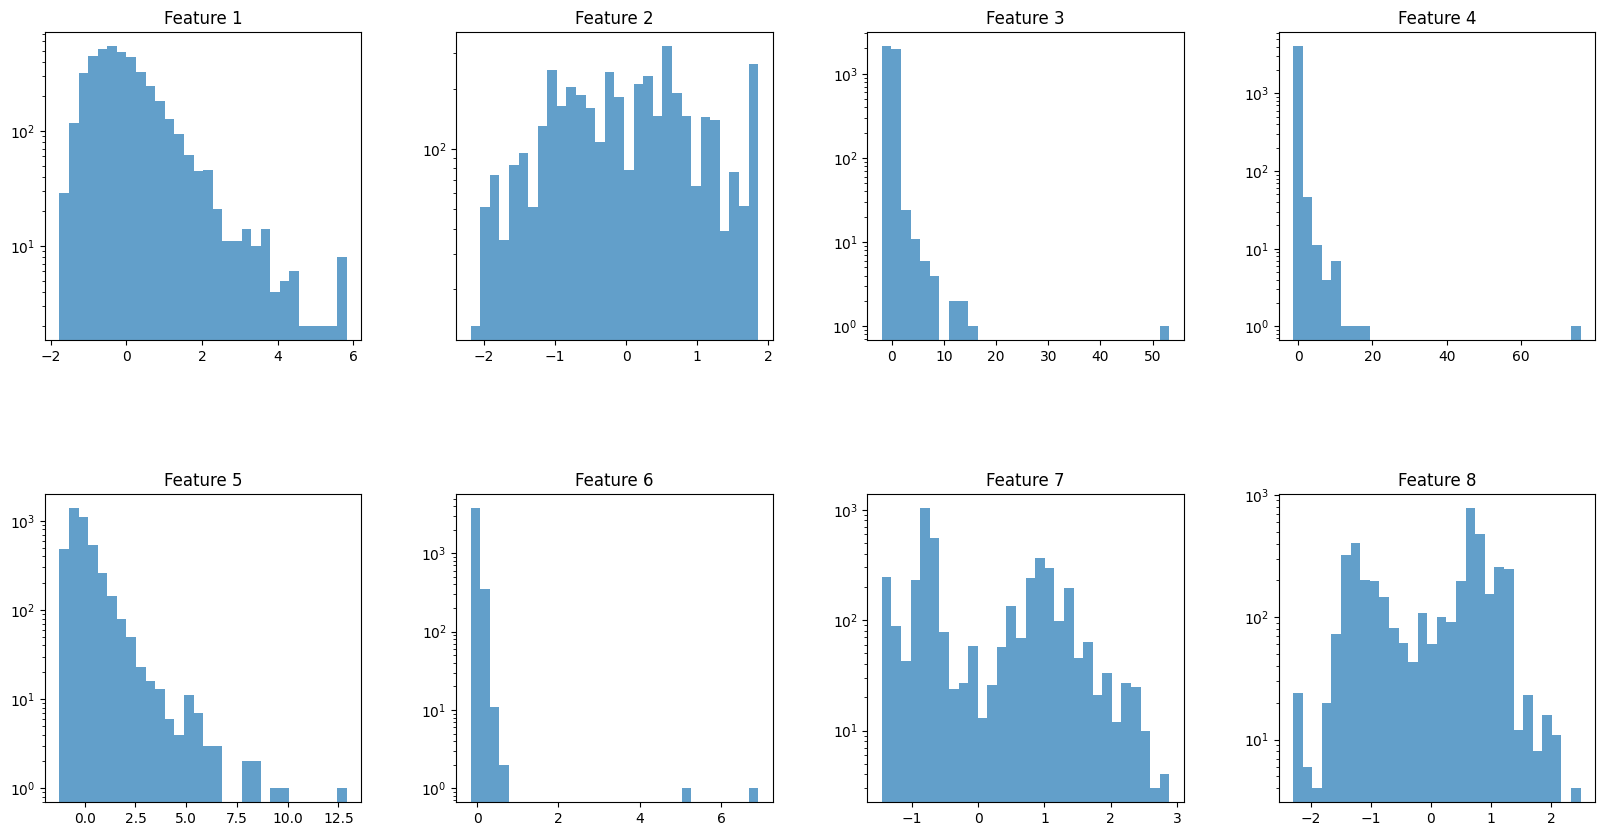

In [10]:
import matplotlib.pyplot as plt

# Assuming X_test is defined and has the shape (4128, 8)

# Set up the matplotlib figure
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))  # Adjust size as needed
fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust spacing between plots as needed

# Iterate over all features (columns) in X_test
for i in range(8):
    # Determine the position of the subplot
    row = i // 4
    col = i % 4
    ax = axs[row, col]

    # Plot the histogram for the i-th feature
    ax.hist(X_test_scaled[:, i], bins=30, alpha=0.7, log=True)
    ax.set_title(f'Feature {i+1}')

# Display the plot
plt.show()


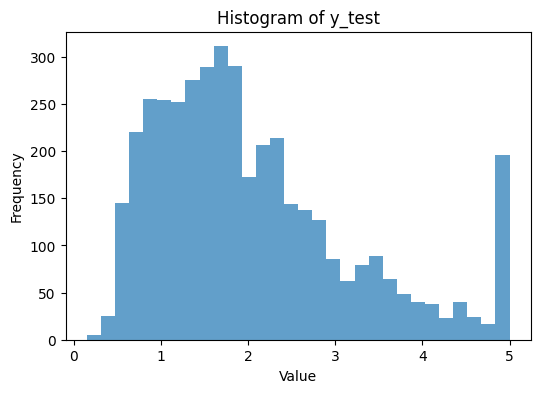

In [11]:
# Plotting the histogram for y_test
plt.figure(figsize=(6, 4))  # Adjust figure size as needed
plt.hist(y_test.ravel(), bins=30, alpha=0.7)  # Use .ravel() to flatten y_test to 1D
plt.title('Histogram of y_test')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

### Linear Regression

In [12]:
# Initialize and train a linear regression model on the scaled data
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# Predict on the scaled training set and the scaled test set
y_train_pred = lin_reg.predict(X_train_scaled)
y_test_pred = lin_reg.predict(X_test_scaled)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f'Training Mean Squared Error: {train_mse:.4f}')
print(f'Test Mean Squared Error: {test_mse:.4f}')

# Coefficients and Intercept
print('Intercept:', lin_reg.intercept_)
print('Coefficients:', lin_reg.coef_)

Training Mean Squared Error: 0.5179
Test Mean Squared Error: 0.5559
Intercept: 2.071946937378619
Coefficients: [ 0.85438303  0.12254624 -0.29441013  0.33925949 -0.00230772 -0.0408291
 -0.89692888 -0.86984178]


In [13]:
# without scaling

#Training Mean Squared Error: 0.5179
#Test Mean Squared Error: 0.5559
#Intercept: -37.02327770606391
#Coefficients: [ 4.48674910e-01  9.72425752e-03 -1.23323343e-01  7.83144907e-01  -2.02962058e-06 -3.52631849e-03 -4.19792487e-01 -4.33708065e-01]

### Bayesian Linear Regression with PyMC

In [14]:
# Define the model
with pm.Model() as model_lin:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=X_train.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    mu = alpha + pm.math.dot(X_train_scaled, beta)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y_train)

    # Sample from the posterior
    idata_lin = pm.sample(500, chains=2) # lengthy: use burn-in of 1000 and 1000 draws for 1 chain


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

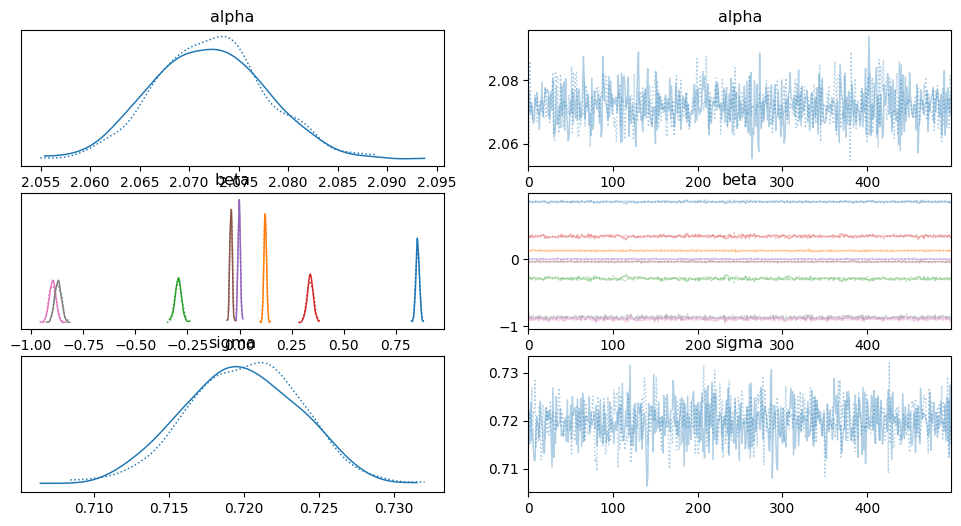

In [15]:
import arviz as az
az.plot_trace(idata_lin)

In [16]:
pos_alpha = idata_lin.posterior['alpha'].mean(axis=0).values
pos_betas = idata_lin.posterior['beta'].mean(axis=0).values

#print(np.shape(pos_alpha))
print(np.shape(pos_betas))


#pos_alpha = pos_alpha.reshape((np.shape(pos_alpha)[1],))

#pos_betas = pos_betas.reshape((np.shape(pos_betas)[1],np.shape(pos_betas)[2]))


(500, 8)


In [17]:
pos_y_test = pos_alpha[:, np.newaxis] + np.dot(pos_betas, X_test_scaled.T)
pos_y_train = pos_alpha[:, np.newaxis] + np.dot(pos_betas, X_train_scaled.T)

print(np.shape(pos_y_test), type(pos_y_test))

pos_y_test_mean = np.mean(pos_y_test, axis=0)
pos_y_train_mean = np.mean(pos_y_train, axis=0)

print(np.shape(pos_y_test_mean))

pos_y_test_lower = np.percentile(pos_y_test,3, axis=0)
pos_y_test_upper = np.percentile(pos_y_test,97, axis=0)
pos_y_train_lower = np.percentile(pos_y_train,3, axis=0)
pos_y_train_upper = np.percentile(pos_y_train,97, axis=0)
print(np.shape(pos_y_test_lower))

for i in range(len(y_test)):
  if(i%50==0):
    print(f"true: {y_test[i]:1.4f}, y_test_pred: {y_test_pred[i]:1.4f}, Bayes mean: {pos_y_test_mean[i]:1.4f}, range: ({pos_y_test_lower[i]:1.4f}, {pos_y_test_upper[i]:1.4f})")

(500, 4128) <class 'numpy.ndarray'>
(4128,)
(4128,)
true: 0.4770, y_test_pred: 0.7191, Bayes mean: 0.7192, range: (0.7056, 0.7333)
true: 2.5190, y_test_pred: 2.4037, Bayes mean: 2.4044, range: (2.3864, 2.4241)
true: 0.9970, y_test_pred: 1.5178, Bayes mean: 1.5171, range: (1.4989, 1.5334)
true: 1.6880, y_test_pred: 1.5097, Bayes mean: 1.5094, range: (1.4917, 1.5262)
true: 2.9790, y_test_pred: 2.3937, Bayes mean: 2.3947, range: (2.3705, 2.4199)
true: 2.2500, y_test_pred: 1.0502, Bayes mean: 1.0507, range: (1.0369, 1.0658)
true: 0.8690, y_test_pred: 0.6687, Bayes mean: 0.6687, range: (0.6496, 0.6863)
true: 1.6250, y_test_pred: 1.4168, Bayes mean: 1.4169, range: (1.3918, 1.4403)
true: 3.7000, y_test_pred: 2.5336, Bayes mean: 2.5345, range: (2.5154, 2.5534)
true: 3.9550, y_test_pred: 2.8634, Bayes mean: 2.8643, range: (2.8492, 2.8807)
true: 1.1940, y_test_pred: 2.2113, Bayes mean: 2.2122, range: (2.1932, 2.2312)
true: 0.9180, y_test_pred: 0.9937, Bayes mean: 0.9933, range: (0.9728, 1.0148)


In [18]:
#--- comparing Linear Regression with Bayesian Linear Regression

print("LINEAR REGRESSION")
print(f'Training Mean Squared Error: {train_mse:.4f}')
print(f'Test Mean Squared Error: {test_mse:.4f}')
print("\n")

# Evaluate the model
train_mse_bayes = mean_squared_error(y_train, pos_y_train_mean)
test_mse_bayes  = mean_squared_error(y_test, pos_y_test_mean)

print("BAYESIAN LINEAR REGRESSION")
print(f'Training Mean Squared Error: {train_mse_bayes:.4f}')
print(f'Test Mean Squared Error: {test_mse_bayes:.4f}')


LINEAR REGRESSION
Training Mean Squared Error: 0.5179
Test Mean Squared Error: 0.5559


BAYESIAN LINEAR REGRESSION
Training Mean Squared Error: 0.5179
Test Mean Squared Error: 0.5559


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

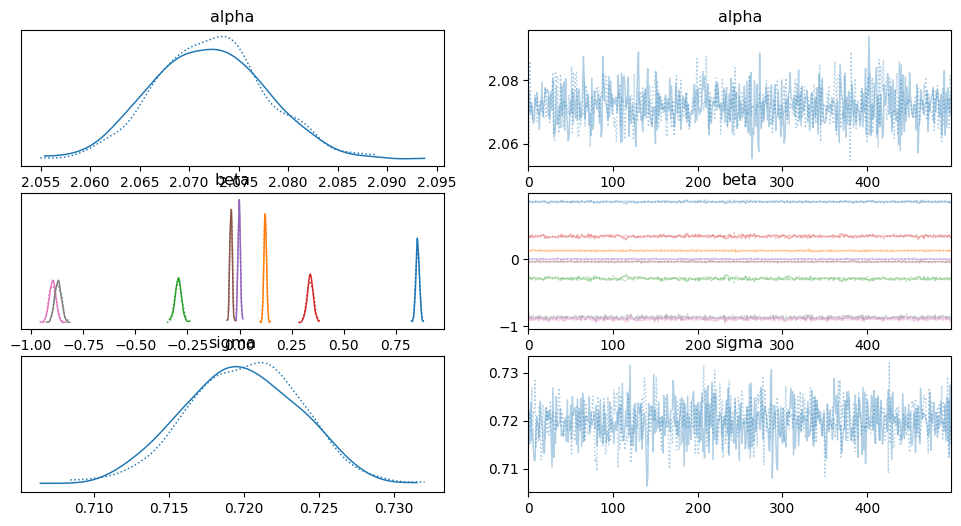

In [19]:
az.plot_trace(idata_lin)

In [20]:
az.summary(idata_lin)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.072,0.006,2.062,2.083,0.000,0.0,1268.0,769.0,1.00
beta[0],0.854,0.009,0.837,0.870,0.000,0.0,696.0,623.0,1.00
beta[1],0.123,0.006,0.111,0.134,0.000,0.0,1017.0,842.0,1.00
beta[2],-0.294,0.016,-0.323,-0.261,0.001,0.0,561.0,435.0,1.00
beta[3],0.339,0.015,0.311,0.369,0.001,0.0,638.0,494.0,1.01
beta[4],-0.002,0.006,-0.013,0.009,0.000,0.0,1142.0,774.0,1.01
beta[5],-0.041,0.006,-0.051,-0.031,0.000,0.0,1186.0,750.0,1.00
beta[6],-0.897,0.017,-0.925,-0.862,0.001,0.0,663.0,677.0,1.00
beta[7],-0.870,0.017,-0.903,-0.842,0.001,0.0,695.0,717.0,1.00
sigma,0.720,0.004,0.713,0.727,0.000,0.0,1087.0,815.0,1.00


### Polynomial Linear regression

In [21]:
# Define the model
with pm.Model() as model_pol:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=X_train.shape[1])
    gamma = pm.Normal('gamma', mu=0, sigma=10, shape=X_train.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=1)


    # Expected value of outcome
    mu = alpha + pm.math.dot(X_train_scaled, beta) + pm.math.dot(X_train_scaled**2, gamma)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y_train)


    # Sample from the posterior
    idata_pol = pm.sample(500, chains=2) #

In [22]:
az.summary(idata_pol)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.055,0.012,2.034,2.078,0.000,0.0,1222.0,623.0,1.00
beta[0],0.999,0.012,0.977,1.021,0.000,0.0,806.0,570.0,1.00
beta[1],0.135,0.006,0.124,0.147,0.000,0.0,1257.0,771.0,1.00
beta[2],-0.437,0.017,-0.468,-0.404,0.001,0.0,786.0,774.0,1.00
beta[3],0.536,0.017,0.507,0.569,0.001,0.0,706.0,651.0,1.00
beta[4],-0.006,0.007,-0.019,0.008,0.000,0.0,1376.0,878.0,1.00
beta[5],-0.140,0.017,-0.172,-0.109,0.001,0.0,946.0,644.0,1.00
beta[6],-0.933,0.020,-0.971,-0.897,0.001,0.0,802.0,635.0,1.00
beta[7],-0.893,0.018,-0.930,-0.862,0.001,0.0,821.0,699.0,1.00
gamma[0],-0.050,0.003,-0.056,-0.045,0.000,0.0,1313.0,783.0,1.00


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

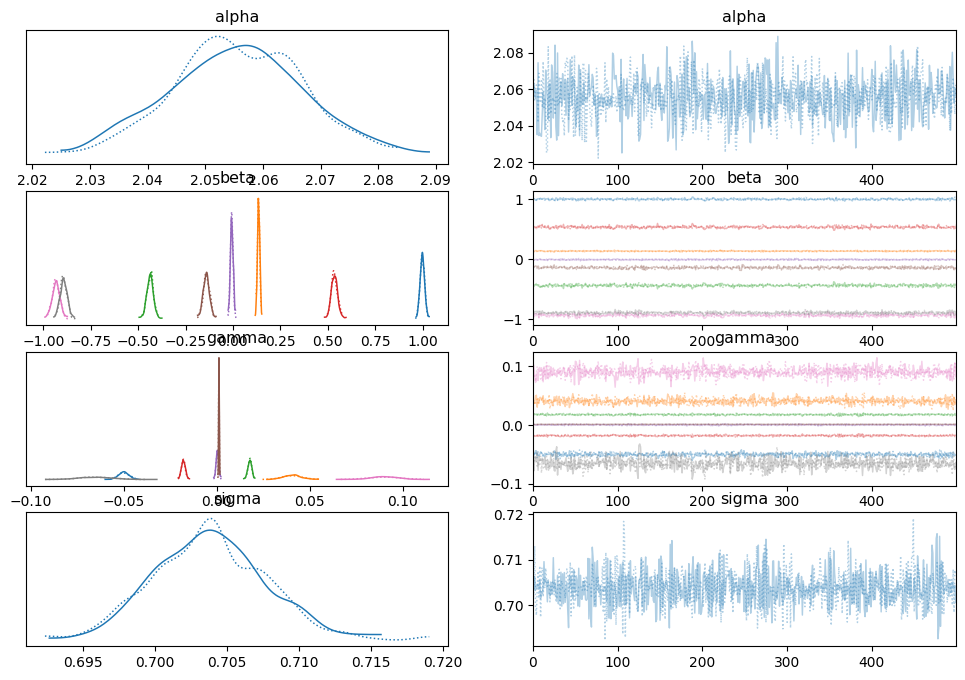

In [24]:
az.plot_trace(idata_pol, compact=True)

In [25]:
pos_alpha_pol = idata_pol.posterior['alpha'].mean(axis=0).values
pos_betas_pol = idata_pol.posterior['beta'].mean(axis=0).values
pos_gammas_pol = idata_pol.posterior['gamma'].mean(axis=0).values

pos_y_test_pol = pos_alpha_pol[:, np.newaxis] + np.dot(pos_betas_pol, X_test_scaled.T) + np.dot(pos_gammas_pol, (X_test_scaled**2).T)
pos_y_test_mean_pol = np.mean(pos_y_test_pol, axis=0)

pos_y_train_pol = pos_alpha_pol[:, np.newaxis] + np.dot(pos_betas_pol, X_train_scaled.T) + np.dot(pos_gammas_pol, (X_train_scaled**2).T)
pos_y_train_mean_pol = np.mean(pos_y_train_pol, axis=0)

pos_y_test_lower_pol = np.percentile(pos_y_test_pol,3, axis=0)
pos_y_test_upper_pol = np.percentile(pos_y_test_pol,97, axis=0)

pos_y_train_lower_pol = np.percentile(pos_y_train_pol,3, axis=0)
pos_y_train_upper_pol = np.percentile(pos_y_train_pol,97, axis=0)


for i in range(len(y_test)):
  if(i%50==0):
    print(f"true: {y_test[i]:1.4f}, y_test_pred: {y_test_pred[i]:1.4f}, Bayes mean: {pos_y_test_mean_pol[i]:1.4f}, range: ({pos_y_test_lower_pol[i]:1.4f}, {pos_y_test_upper_pol[i]:1.4f})")

true: 0.4770, y_test_pred: 0.7191, Bayes mean: 0.4905, range: (0.4688, 0.5122)
true: 2.5190, y_test_pred: 2.4037, Bayes mean: 2.3686, range: (2.3468, 2.3912)
true: 0.9970, y_test_pred: 1.5178, Bayes mean: 1.5412, range: (1.5231, 1.5602)
true: 1.6880, y_test_pred: 1.5097, Bayes mean: 1.4621, range: (1.4430, 1.4846)
true: 2.9790, y_test_pred: 2.3937, Bayes mean: 2.4007, range: (2.3707, 2.4264)
true: 2.2500, y_test_pred: 1.0502, Bayes mean: 1.0054, range: (0.9890, 1.0202)
true: 0.8690, y_test_pred: 0.6687, Bayes mean: 0.3344, range: (0.3096, 0.3625)
true: 1.6250, y_test_pred: 1.4168, Bayes mean: 1.2926, range: (1.2636, 1.3261)
true: 3.7000, y_test_pred: 2.5336, Bayes mean: 2.6589, range: (2.6352, 2.6854)
true: 3.9550, y_test_pred: 2.8634, Bayes mean: 2.8740, range: (2.8583, 2.8905)
true: 1.1940, y_test_pred: 2.2113, Bayes mean: 2.3069, range: (2.2848, 2.3344)
true: 0.9180, y_test_pred: 0.9937, Bayes mean: 0.8605, range: (0.8292, 0.8922)
true: 0.8550, y_test_pred: 1.4220, Bayes mean: 1.349

In [26]:
np.shape(y_train)

(16512,)

In [ ]:
np.shape(pos_y_train_mean_pol)

(16512,)

In [27]:
#--- comparing Linear Regression with Polynomial Bayesian Linear Regression

print("LINEAR REGRESSION")
print(f'Training Mean Squared Error: {train_mse:.4f}')
print(f'Test Mean Squared Error: {test_mse:.4f}')
print("\n")

# Evaluate the model
train_mse_bayes_pol = mean_squared_error(y_train, pos_y_train_mean_pol)
test_mse_bayes_pol  = mean_squared_error(y_test, pos_y_test_mean_pol)

print("BAYESIAN LINEAR REGRESSION")
print(f'Training Mean Squared Error: {train_mse_bayes:.4f}')
print(f'Test Mean Squared Error: {test_mse_bayes:.4f}')
print("\n")

print("BAYESIAN POLYNOMIAL REGRESSION")
print(f'Training Mean Squared Error: {train_mse_bayes_pol:.4f}')
print(f'Test Mean Squared Error: {test_mse_bayes_pol:.4f}')


LINEAR REGRESSION
Training Mean Squared Error: 0.5179
Test Mean Squared Error: 0.5559


BAYESIAN LINEAR REGRESSION
Training Mean Squared Error: 0.5179
Test Mean Squared Error: 0.5559


BAYESIAN POLYNOMIAL REGRESSION
Training Mean Squared Error: 0.4948
Test Mean Squared Error: 0.8431


### Model Comparison

In [ ]:
#---------- Posterior Predictive Checks

In [28]:
y_l = pm.sample_posterior_predictive(idata_lin,model=model_lin)

In [29]:
y_p = pm.sample_posterior_predictive(idata_pol,model=model_pol)

([], [])

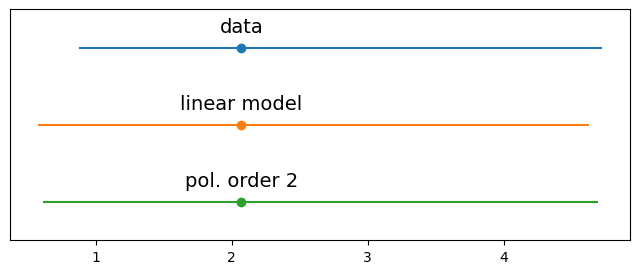

In [30]:
plt.figure(figsize=(8,3))

y_o  = y_train
y_l  = y_l.posterior_predictive['Y_obs'].mean(axis=0).mean(axis=0).values
y_p  = y_p.posterior_predictive['Y_obs'].mean(axis=0).mean(axis=0).values


data = [y_o, y_l, y_p]
labels = ['data', 'linear model', 'pol. order 2']

for i, d in enumerate(data):
  mean = d.mean()
  err = np.percentile(d, [25,75])
  plt.errorbar(mean,-i,xerr=[[err[0]],[err[1]]], fmt='o')
  plt.text(mean,-i+0.2, labels[i], ha='center', fontsize=14)

plt.ylim([-i-0.5,0.5])
plt.yticks([])

In [ ]:
#---------- Information Criteria

In [31]:
with model_lin:
    pm.compute_log_likelihood(idata_lin)


with model_pol:
    pm.compute_log_likelihood(idata_pol)

In [32]:
idata_pol

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [33]:
df_compare = az.compare({"model_l": idata_lin, "model_p2": idata_pol}, ic='loo') #loo is recommended
df_compare

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_p2,0,-17660.89096,55.707887,0.00000,0.999512,145.923506,0.000000,True,log
model_l,1,-18016.02250,24.414516,355.13154,0.000488,144.222960,44.348735,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

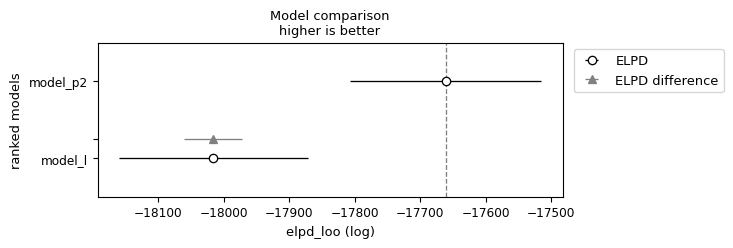

In [34]:
az.plot_compare(df_compare, insample_dev=False)

**BONUS 1**

In [35]:
with pm.Model() as model_lin_bonus:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=X_train.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    mu = alpha + pm.math.dot(X_train_scaled, beta)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y_train)

    # Sample from the posterior
    trace_lin_bonus = pm.sample_smc()

In [255]:
# Define the model
with pm.Model() as model_pol_bonus:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=X_train.shape[1])
    gamma = pm.Normal('gamma', mu=0, sigma=1, shape=X_train.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=1) #


    # Expected value of outcome
    mu = alpha + pm.math.dot(X_train_scaled, beta) + pm.math.dot(X_train_scaled**2, gamma)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y_train)


    # Sample from the posterior
    trace_pol_bonus = pm.sample_smc()

In [258]:
log_marg_lkd_lin = trace_lin_bonus.sample_stats["log_marginal_likelihood"].values
log_marg_lkd_pol = trace_pol_bonus.sample_stats["log_marginal_likelihood"].values

In [261]:
chain =2

list_lin = []
list_pol = []

for i in range(chain):
  tmp_lin = np.array(log_marg_lkd_lin[0][i]).tolist()
  tmp_pol = np.array(log_marg_lkd_pol[0][i]).tolist()
  filtered_lin = [x for x in tmp_lin if not np.isnan(x)]
  filtered_pol = [x for x in tmp_pol if not np.isnan(x)]
  list_lin.append(filtered_lin)
  list_pol.append(filtered_pol)


unique_lin = list(set(item for sublist in list_lin for item in sublist))
unique_pol = list(set(item for sublist in list_pol for item in sublist))



print(unique_lin)
print(unique_pol)


[-18187.130496876445, -18281.123857578135]
[-17757.13224203208, -17908.15446008692]


In [263]:
BF_smc = np.exp(
    np.mean(unique_pol) -
    np.mean(unique_lin)
    )
np.round(BF_smc).item()

2.3025564065890448e+174

**BONUS 2**

In [264]:
# Define the model
with pm.Model() as model_rob:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=X_train.shape[1])
    gamma = pm.Normal('gamma', mu=0, sigma=10, shape=X_train.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=1)

    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1)

    # Expected value of outcome
    mu = alpha + pm.math.dot(X_train_scaled, beta) + pm.math.dot(X_train_scaled**2, gamma)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.StudentT('Y_obs', mu=mu, sigma=sigma, nu=ν, observed=y_train) #ϵ



    # Sample from the posterior
    idata_rob = pm.sample(500, chains=2) # lengthy: use burn-in of 1000 and 1000 draws for 1 chain

In [265]:
#--- comparing Linear Regression with Polynomial Bayesian Linear Regression

pos_alpha_rob = idata_rob.posterior['alpha'].mean(axis=0).values
pos_betas_rob = idata_rob.posterior['beta'].mean(axis=0).values
pos_gammas_rob = idata_rob.posterior['gamma'].mean(axis=0).values

pos_y_test_rob = pos_alpha_rob[:, np.newaxis] + np.dot(pos_betas_rob, X_test_scaled.T) + np.dot(pos_gammas_rob, (X_test_scaled**2).T)
pos_y_test_mean_rob = np.mean(pos_y_test_rob, axis=0)

pos_y_train_rob = pos_alpha_rob[:, np.newaxis] + np.dot(pos_betas_rob, X_train_scaled.T) + np.dot(pos_gammas_rob, (X_train_scaled**2).T)
pos_y_train_mean_rob = np.mean(pos_y_train_rob, axis=0)

#pos_y_test_lower_rob = np.percentile(pos_y_test_rob,3, axis=0)
#pos_y_test_upper_rob = np.percentile(pos_y_test_rob,97, axis=0)

#pos_y_train_lower_rob = np.percentile(pos_y_train_rob,3, axis=0)
#pos_y_train_upper_rob = np.percentile(pos_y_train_rob,97, axis=0)


print("LINEAR REGRESSION")
print(f'Training Mean Squared Error: {train_mse:.4f}')
print(f'Test Mean Squared Error: {test_mse:.4f}')
print("\n")

# Evaluate the model
train_mse_bayes_rob = mean_squared_error(y_train, pos_y_train_mean_rob)
test_mse_bayes_rob  = mean_squared_error(y_test, pos_y_test_mean_rob)

print("BAYESIAN LINEAR REGRESSION")
print(f'Training Mean Squared Error: {train_mse_bayes:.4f}')
print(f'Test Mean Squared Error: {test_mse_bayes:.4f}')
print("\n")

print("BAYESIAN POLYNOMIAL REGRESSION")
print(f'Training Mean Squared Error: {train_mse_bayes_pol:.4f}')
print(f'Test Mean Squared Error: {test_mse_bayes_pol:.4f}')

print("BAYESIAN POLYNOMIAL ROBUST REGRESSION")
print(f'Training Mean Squared Error: {train_mse_bayes_rob:.4f}')
print(f'Test Mean Squared Error: {test_mse_bayes_rob:.4f}')



LINEAR REGRESSION
Training Mean Squared Error: 0.5179
Test Mean Squared Error: 0.5559


BAYESIAN LINEAR REGRESSION
Training Mean Squared Error: 0.5179
Test Mean Squared Error: 0.5559


BAYESIAN POLYNOMIAL REGRESSION
Training Mean Squared Error: 0.4948
Test Mean Squared Error: 0.8431
BAYESIAN POLYNOMIAL ROBUST REGRESSION
Training Mean Squared Error: 1.3732
Test Mean Squared Error: 2.4885
